In [1]:
#Loads some parameters
import CloudDataset128e
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import torchvision.transforms.v2 as v2
import torch.nn as nn
from torch.nn.functional import relu
import torch.optim as optim
batch_size = 8

#imports state of the art model.
#model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50')
print("Load successfull")


Load successfull


<class 'torch.Tensor'>
torch.Size([8, 3, 128, 128])
torch.Size([8, 5, 128, 128])


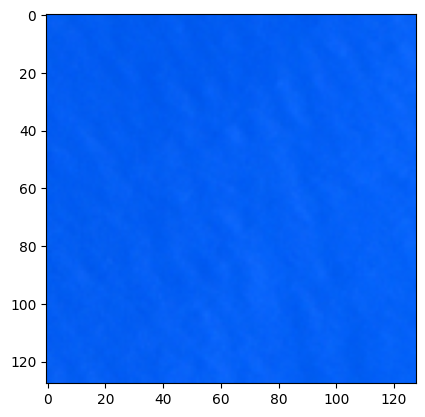

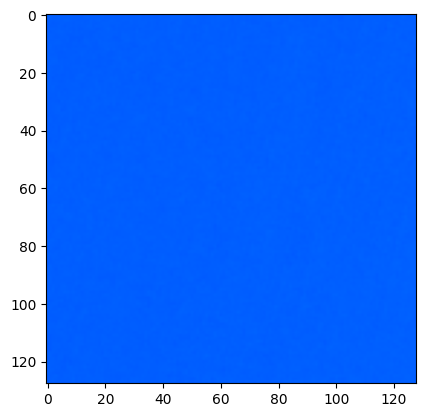

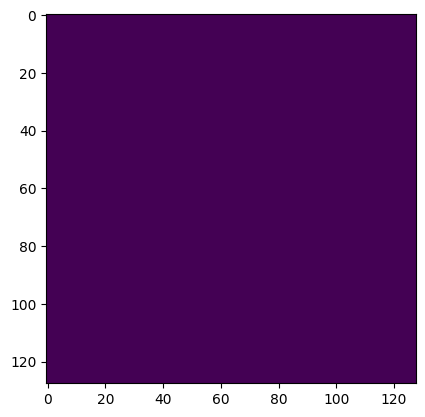

In [22]:
transform = {
    "image": v2.Compose([
    transforms.Resize(size=(256,256)),
]),
    "mask": v2.Compose([
    transforms.Resize(size=(256,256)),
])}

# Get the dataset of the CloudDataset
dataset = CloudDataset128e.CloudDataset("data\\train",transform=transform)

# Creates validation/training dataset with 20/80 split
validation_dataset, training_dataset = torch.utils.data.random_split(dataset,[0.2, 0.8])

# Create a DataLoaders from the datasets.
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)

# Creates an iterator and plots the pictures
it = iter(training_loader)
images, labels, images_disp = next(it)

print(type(images_disp))
print(images_disp.shape)
print(labels.shape)

plt.figure()
plt.imshow(images_disp[0][:3].permute(1,2,0))
plt.show()


imagesd = images-images.min(1, keepdim=True)[0]
imagesd /= imagesd.max(1, keepdim=True)[0]

plt.figure()
plt.imshow(imagesd[0][:3].permute(1,2,0))
plt.show()

plt.figure()
i=4
plt.imshow(labels[0][i:i+1].permute(1,2,0))
plt.show()

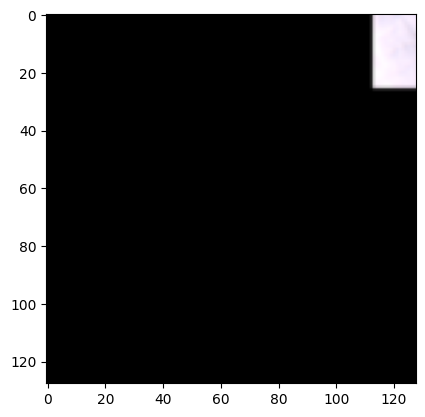

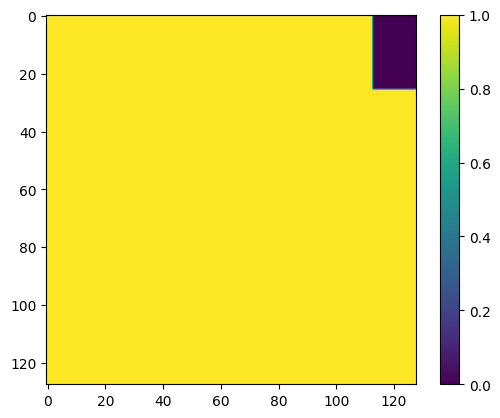

In [26]:
# Grabs next bath of pictures and displays the first, run multiple times for different plots
images, labels, images_disp = next(it)

plt.figure()
plt.imshow(images_disp[0][:3].permute(1,2,0))
plt.show()

plt.figure()
i=0
img = plt.imshow(labels[0][i:i+1].permute(1,2,0),vmin=0,vmax=1)
plt.colorbar(img)
plt.show()

In [27]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 128x128x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 128x128x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 128x128x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 64x64x64

        # input: 64x64x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 64x64x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 64x64x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x128

        # input: 32x32x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 32x32x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 32x32x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 16x16x256

        # input: 16x16x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 16x16x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 16x16x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 8x8x512

        # input: 8x8x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 8x8x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 8x8x1024
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 4x4x1024

        # input: 4x4x1024
        self.e61 = nn.Conv2d(1024, 2048, kernel_size=3, padding=1) # output: 4x4x2048
        self.e62 = nn.Conv2d(2048, 2048, kernel_size=3, padding=1) # output: 4x4x2048


        # Decoder
        # input: 4x4x2048
        self.upconv0 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2) # output: 8x8x2048
        self.d01 = nn.Conv2d(2048, 1024, kernel_size=3, padding=1) # output: 8x8x1024
        self.d02 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 8x8x1024


        # input: 8x8x1024
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2) # output: 16x16x1024
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1) # output: 16x16x512
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 16x16x512

        # input: 16x16x512
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) # output: 32x32x512
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1) # output: 32x32x256
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 32x32x256

        # input: 32x32x256
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # output: 64x64x256
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1) # output: 64x64x128
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 64x64x128

        # input: 64x64x128
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # output: 128x128x128
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1) # output: 128x128x64
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 128x128x64

        # Output layer
        # input: 128x128x64
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1) # output: 128 x 128 x n_class
    
    def forward(self, x):
        # Encoder
        #print(x.shape)
        xe11 = relu(self.e11(x))
        #print(xe11.shape)
        xe12 = relu(self.e12(xe11))
        #print(xe12.shape)
        xp1 = self.pool1(xe12)
        #print(xp1.shape)

        xe21 = relu(self.e21(xp1))
        #print(xe21.shape)
        xe22 = relu(self.e22(xe21))
        #print(xe22.shape)
        xp2 = self.pool2(xe22)
        #print(xp2.shape)

        xe31 = relu(self.e31(xp2))
        #print(xe31.shape)
        xe32 = relu(self.e32(xe31))
        #print(xe32.shape)
        xp3 = self.pool3(xe32)
        #print(xp3.shape)

        xe41 = relu(self.e41(xp3))
        #print(xe41.shape)
        xe42 = relu(self.e42(xe41))
        #print(xe42.shape)
        xp4 = self.pool4(xe42)
        #print(xp4.shape)

        xe51 = relu(self.e51(xp4))
        #print(xe51.shape)
        xe52 = relu(self.e52(xe51))
        #print(xe52.shape)
        xp5 = self.pool5(xe52)
        #print(xp5.shape)

        xe61 = relu(self.e61(xp5))
        #print(xe51.shape)
        xe62 = relu(self.e62(xe61))
        #print(xe52.shape)
        
        # Decoder
        xu0 = self.upconv0(xe62)
        xu01 = torch.cat([xu0, xe52], dim=1)
        xd01 = relu(self.d01(xu01))
        xd02 = relu(self.d02(xd01))

        xu1 = self.upconv1(xd02)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out=self.outconv(xd42)

        return out

Epoch: 0 batch_nr: 0 Time: 2.4213543999940157 Time_diff: 2.421356900013052 loss: 2.64650297164917
Epoch: 0 batch_nr: 8 Time: 56.17602949999855 Time_diff: 7.30298410000978 loss: 2.880745198991564

 New best loss: 2.5679494937260947


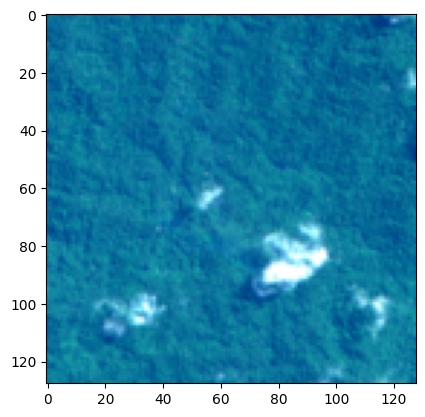

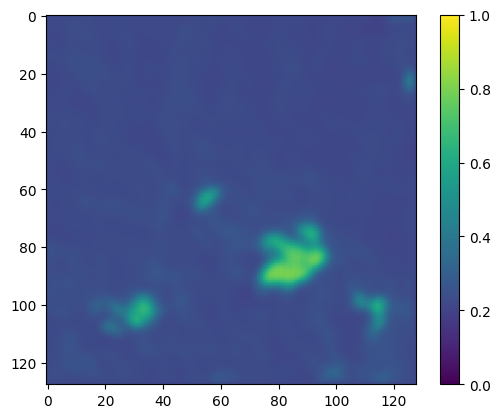

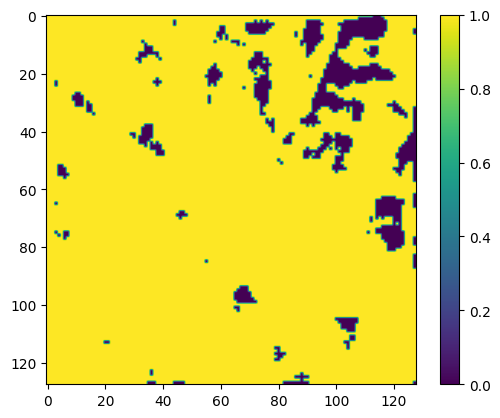

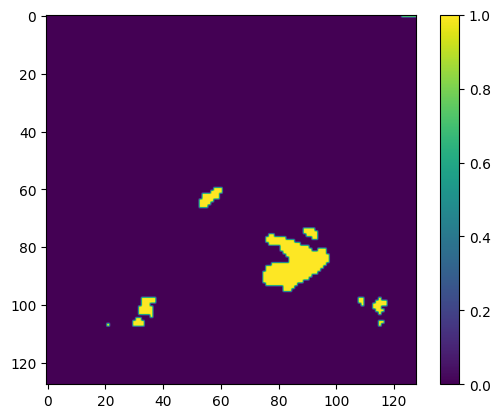


Epoch: 1 batch_nr: 7 Time: 125.49747679999564 Time_diff: 7.09242020000238 loss: 2.5427719056606293
new val loss: 4.09801189104716
Epoch: 2 batch_nr: 6 Time: 188.01867180000409 Time_diff: 6.902267399971606 loss: 2.509852579661778
new val loss: 2.5967489083607993
Epoch: 3 batch_nr: 5 Time: 250.00613319998956 Time_diff: 6.919938000006368 loss: 2.5107197761535645

 New best loss: 2.122297008832296


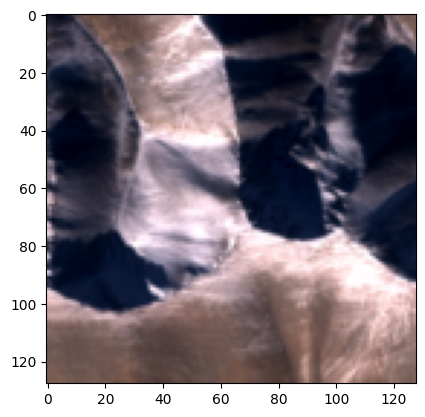

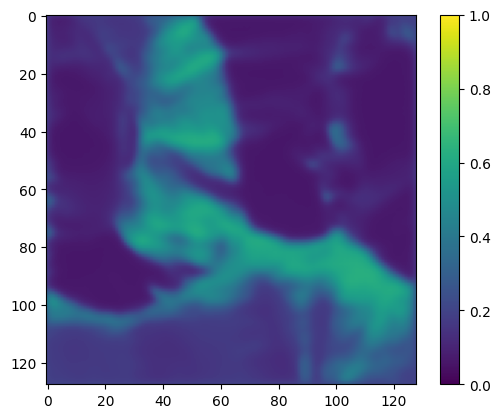

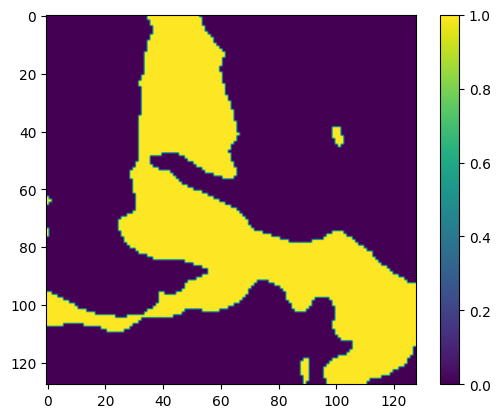

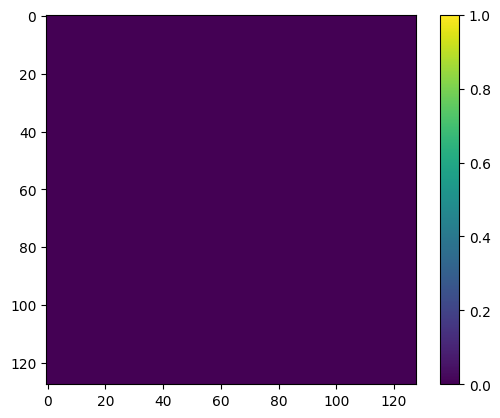


Epoch: 4 batch_nr: 4 Time: 314.5650836999994 Time_diff: 7.0690481000056025 loss: 2.27297728061676
new val loss: 2.3670546213785806
Epoch: 5 batch_nr: 3 Time: 377.38217249998706 Time_diff: 7.181049099977827 loss: 2.2318899035453796
new val loss: 2.5928987661997476
Epoch: 6 batch_nr: 2 Time: 440.33364659998915 Time_diff: 6.846890699991491 loss: 2.605729420979818
new val loss: 2.1751259565353394
Epoch: 7 batch_nr: 1 Time: 500.9459263999888 Time_diff: 6.835172499995679 loss: 2.4582029581069946

 New best loss: 2.1184629599253335


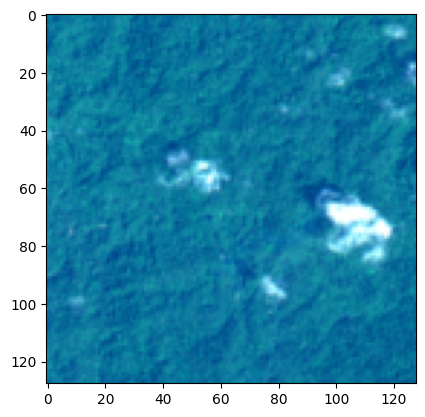

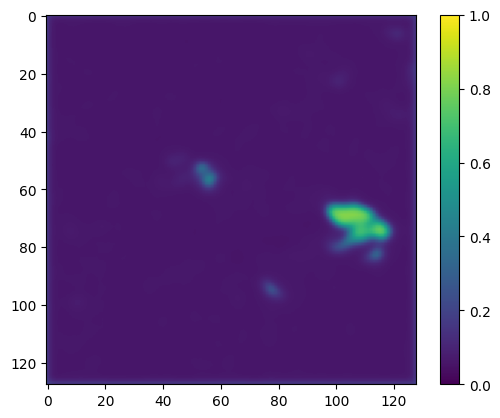

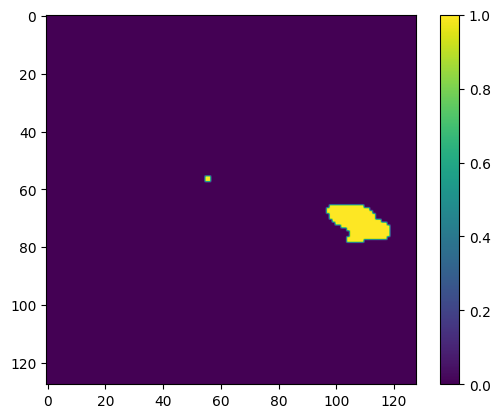

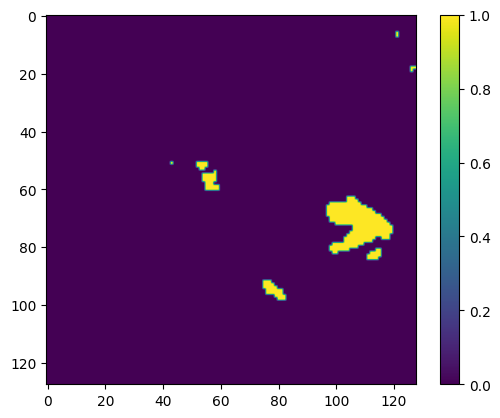


Epoch: 8 batch_nr: 0 Time: 566.117218600004 Time_diff: 17.07426670001587 loss: 1.9429415464401245
Epoch: 8 batch_nr: 8 Time: 622.3208376000111 Time_diff: 7.0194042999937665 loss: 2.0777012242211237
new val loss: 2.378857453664144
Epoch: 9 batch_nr: 7 Time: 686.5408527000109 Time_diff: 7.04154429998016 loss: 2.022521451115608
new val loss: 2.3192684650421143
Epoch: 10 batch_nr: 6 Time: 748.4208038999932 Time_diff: 6.906545800011372 loss: 1.9749742916652135
new val loss: 2.3415905634562173
Epoch: 11 batch_nr: 5 Time: 809.5992987999925 Time_diff: 6.906110300013097 loss: 2.02965780099233

 New best loss: 2.0917133490244546


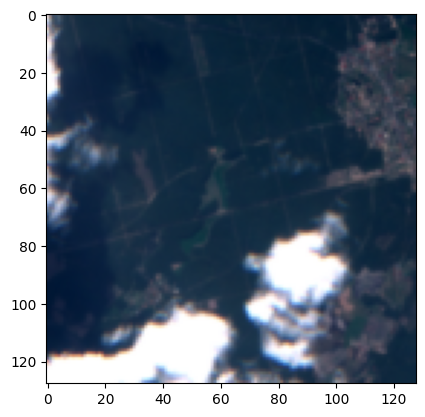

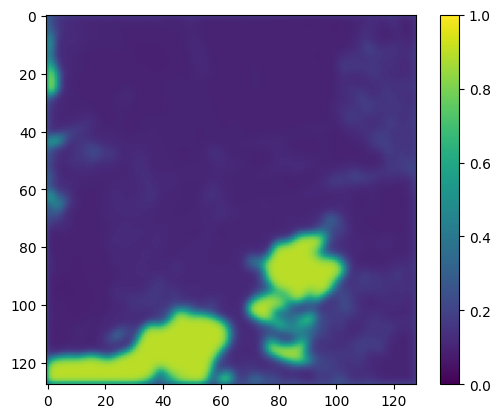

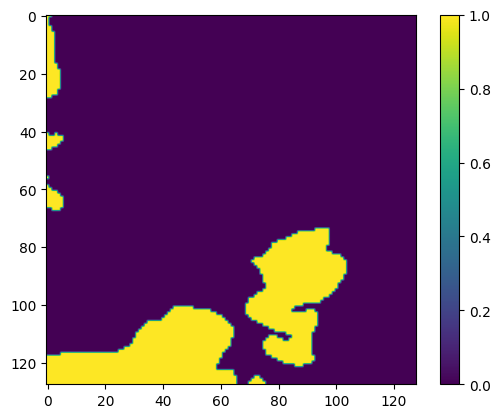

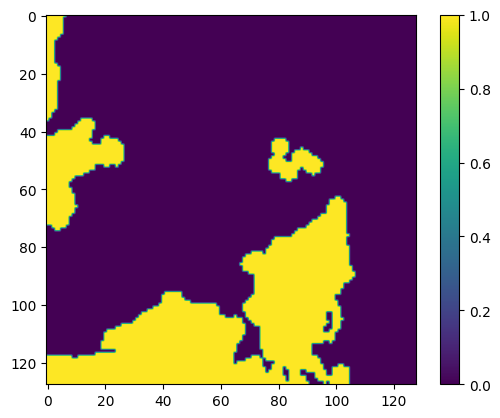


Epoch: 12 batch_nr: 4 Time: 875.6024337999988 Time_diff: 6.864847999997437 loss: 1.88912992477417
new val loss: 2.2150630950927734
Epoch: 13 batch_nr: 3 Time: 938.9632566999935 Time_diff: 7.314462800015463 loss: 1.9288816154003143
new val loss: 2.146891395250956
Epoch: 14 batch_nr: 2 Time: 1000.4166376999929 Time_diff: 6.8696253999951296 loss: 1.8838553428649902

 New best loss: 1.923645814259847


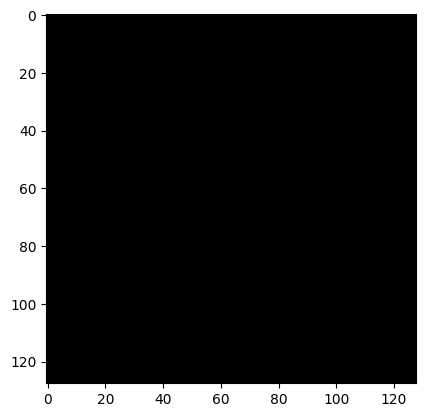

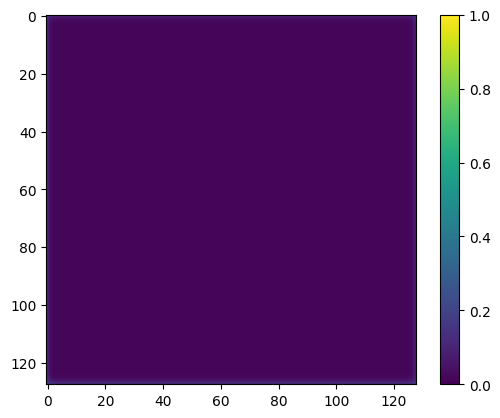

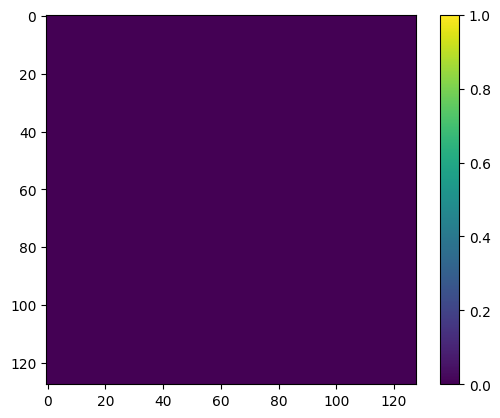

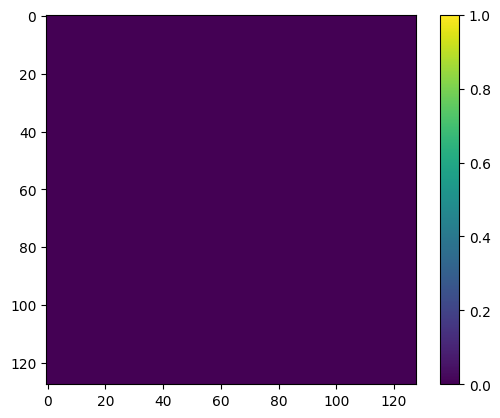


Epoch: 15 batch_nr: 1 Time: 1063.9569002999924 Time_diff: 7.271912700001849 loss: 1.7245756387710571
new val loss: 1.993792215983073
Epoch: 16 batch_nr: 0 Time: 1130.6123411000008 Time_diff: 14.938212699984433 loss: 2.074855327606201
Epoch: 16 batch_nr: 8 Time: 1187.761598699988 Time_diff: 6.671619600005215 loss: 1.8445645570755005
new val loss: 2.074351946512858
Epoch: 17 batch_nr: 7 Time: 1249.4549724000099 Time_diff: 6.922841099993093 loss: 1.8815652430057526
new val loss: 2.0734912554423013
Epoch: 18 batch_nr: 6 Time: 1310.3788410999987 Time_diff: 6.884086999983992 loss: 1.8638931683131628

 New best loss: 1.878514289855957


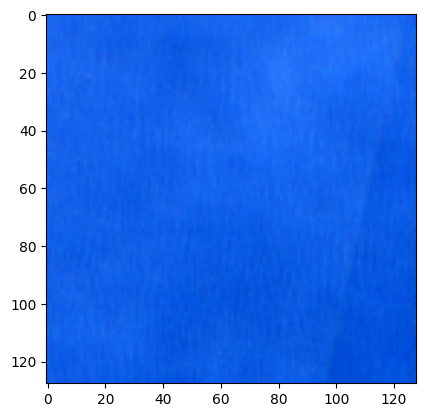

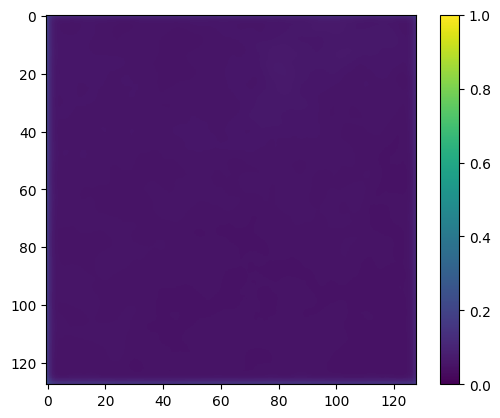

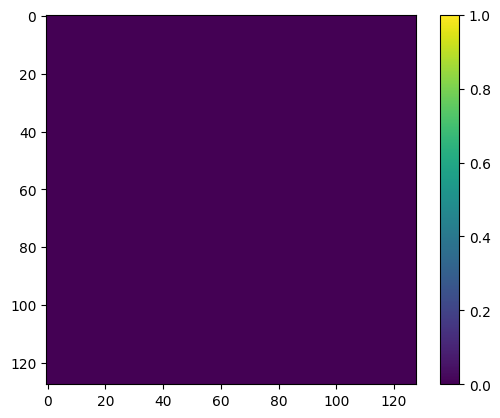

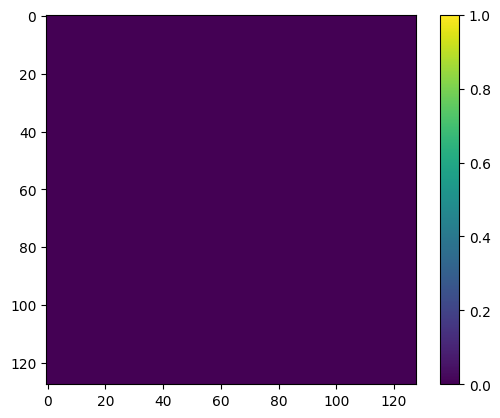


Epoch: 19 batch_nr: 5 Time: 1377.4650781000091 Time_diff: 7.120204599981662 loss: 1.8000731269518535

 New best loss: 1.8680301507314045


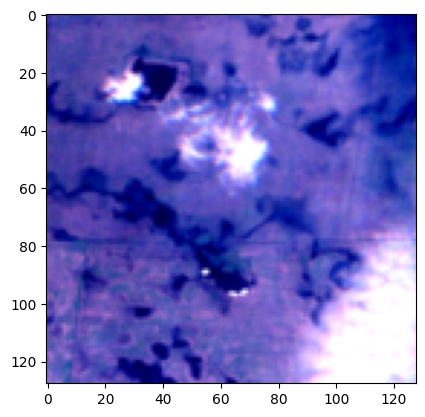

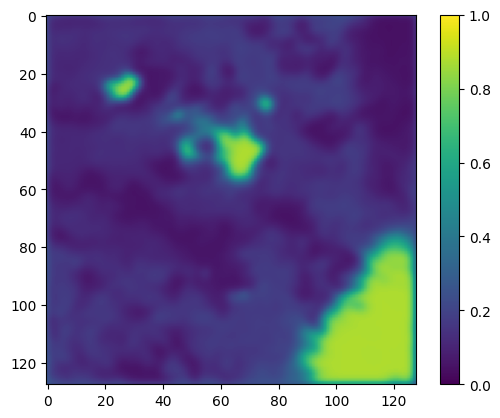

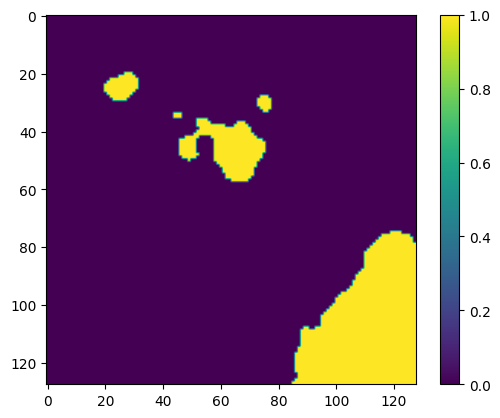

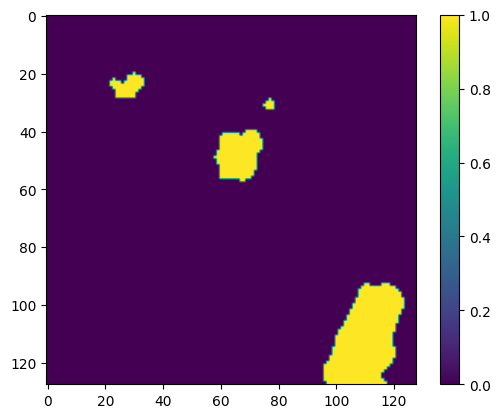


Epoch: 20 batch_nr: 4 Time: 1442.6039691999904 Time_diff: 6.96841349999886 loss: 1.830023503303528

 New best loss: 1.861815094947815


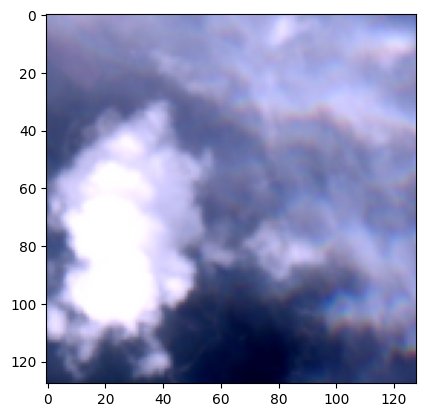

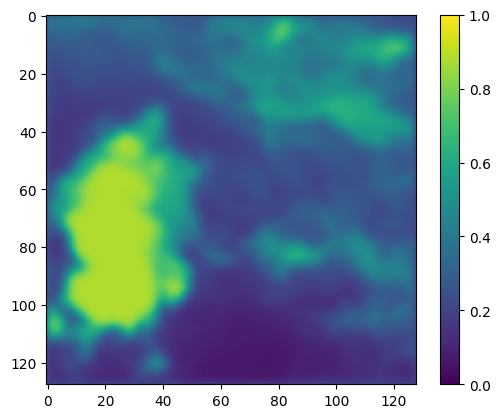

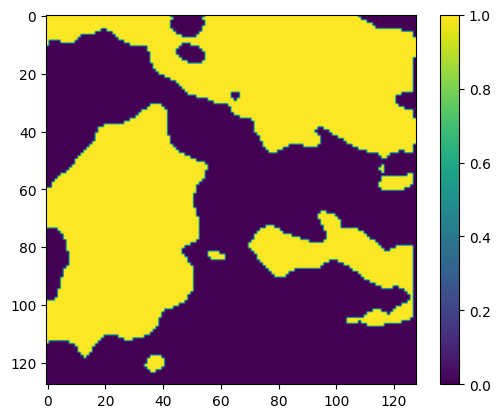

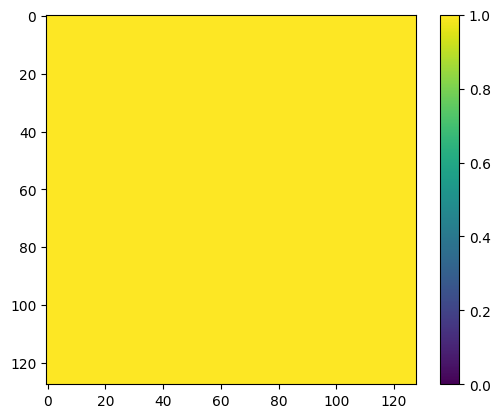


Epoch: 21 batch_nr: 3 Time: 1511.5088052999927 Time_diff: 7.348654000001261 loss: 1.8517588675022125
new val loss: 2.028980016708374
Epoch: 22 batch_nr: 2 Time: 1575.5350040000048 Time_diff: 7.002350800001295 loss: 1.9766242504119873

 New best loss: 1.7182280619939168


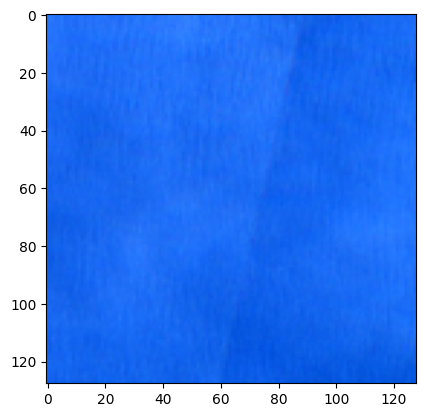

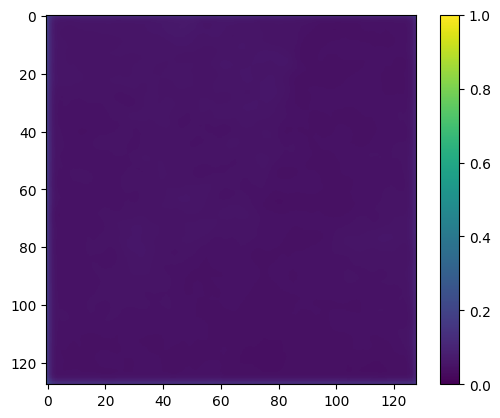

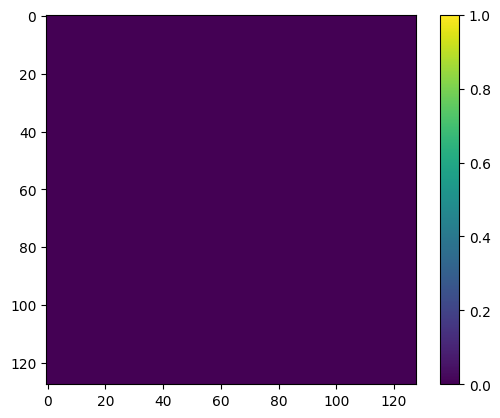

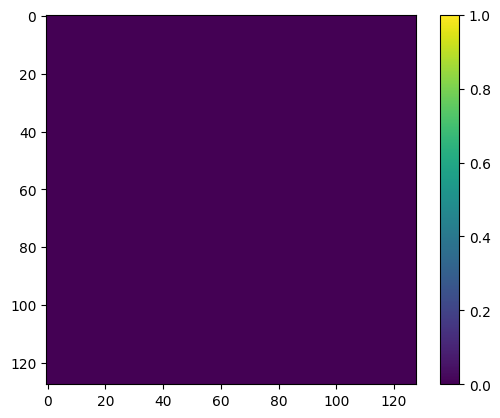


Epoch: 23 batch_nr: 1 Time: 1641.2726211000117 Time_diff: 7.7277707000030205 loss: 1.8817415833473206
new val loss: 2.0538902282714844
Epoch: 24 batch_nr: 0 Time: 1704.2098034000082 Time_diff: 14.54686590001802 loss: 2.0015010833740234
Epoch: 24 batch_nr: 8 Time: 1760.9029804999882 Time_diff: 6.685376499983249 loss: 1.863565484682719
new val loss: 2.0895532766977944
Epoch: 25 batch_nr: 7 Time: 1823.514649699995 Time_diff: 7.0358047999907285 loss: 1.837510883808136
new val loss: 1.789129614830017
Epoch: 26 batch_nr: 6 Time: 1885.539001600002 Time_diff: 7.008701500017196 loss: 1.713851468903678
new val loss: 1.9747323195139568
Epoch: 27 batch_nr: 5 Time: 1947.1077958999958 Time_diff: 7.153884800005471 loss: 1.7375887433687847
new val loss: 2.08414355913798
Epoch: 28 batch_nr: 4 Time: 2015.5832402000087 Time_diff: 7.86926459998358 loss: 1.620151948928833
new val loss: 2.0904818375905356
Epoch: 29 batch_nr: 3 Time: 2082.5654480000085 Time_diff: 6.984638800000539 loss: 1.8456194996833801
n

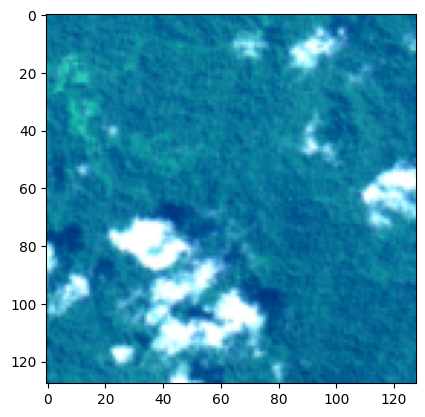

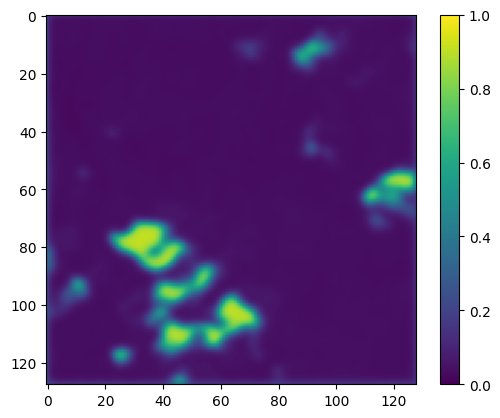

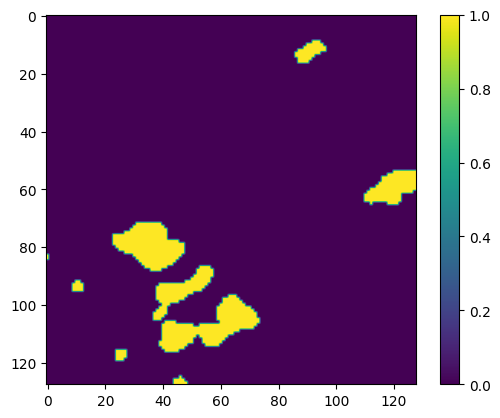

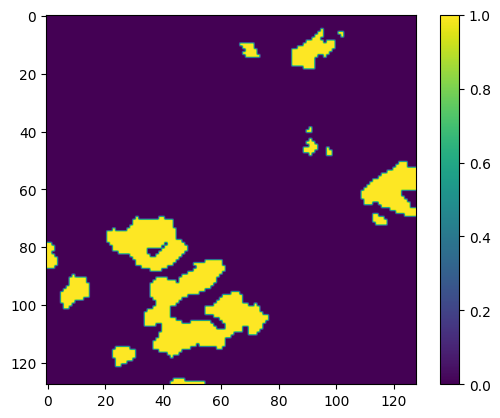


Epoch: 34 batch_nr: 6 Time: 2455.358518199995 Time_diff: 7.217507800000021 loss: 1.6852057150432043
new val loss: 1.8555710315704346
Epoch: 35 batch_nr: 5 Time: 2518.4451096999983 Time_diff: 6.905380900017917 loss: 1.7531211972236633
new val loss: 2.02224338054657
Epoch: 36 batch_nr: 4 Time: 2581.248892600008 Time_diff: 7.775036999984877 loss: 1.8083950757980347
new val loss: 2.0392887592315674
Epoch: 37 batch_nr: 3 Time: 2643.0007952000014 Time_diff: 7.351687399990624 loss: 1.8148930072784424
new val loss: 2.118592937787374
Epoch: 38 batch_nr: 2 Time: 2704.855222299986 Time_diff: 6.948395499988692 loss: 1.672801931699117
new val loss: 1.89207124710083
Epoch: 39 batch_nr: 1 Time: 2766.4525517 Time_diff: 7.034535299986601 loss: 1.6526512503623962
new val loss: 1.7375862995783489
Epoch: 40 batch_nr: 0 Time: 2827.8793853000097 Time_diff: 12.55625009999494 loss: 1.6052290201187134
Epoch: 40 batch_nr: 8 Time: 2883.1042439999874 Time_diff: 6.587894299998879 loss: 1.8397224611706204
new val 

KeyboardInterrupt: 

In [28]:
import copy
from time import perf_counter

epochs=500

def train_model(train_loader, val_loader, model, criterion, optimizer, scheduler):
    start_time = perf_counter()
    time = 0

    best_loss = float('inf')

    train_loss = []
    val_loss = []

    for epoch in range(epochs):
        avg_loss_list = []
        for batch_nr, (images,labels,_) in enumerate(train_loader):
            #Forward pass
            predictions = model(images)
            loss = criterion(predictions,labels.float())
            avg_loss_list.append(loss.item())
            
            if((batch_nr+epoch)%8==0):
                print("Epoch:",epoch,"batch_nr:",batch_nr,"Time:",perf_counter()-start_time,"Time_diff:",perf_counter()-start_time-time,"loss:",(sum(avg_loss_list)/len(avg_loss_list)))
            time=perf_counter()-start_time

            #Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update learning rate
            scheduler.step()

        avg_v_loss_list = []
        for batch_nr, (images_valid,labels_valid,images_disp) in enumerate(val_loader):
            predictions = model(images_valid)
            loss = criterion(predictions,labels_valid.float())
            avg_v_loss_list.append(loss.item())
        
        train_loss.append((sum(avg_loss_list)/len(avg_loss_list)))
        val_loss.append((sum(avg_v_loss_list)/len(avg_v_loss_list)))

        #Finds best model
        if (val_loss[-1]<best_loss):
            best_loss=val_loss[-1]
            best_model = copy.deepcopy(model)
            torch.save(model, 'best_UNET128e_model.pt')
            print("\n New best loss:",best_loss)

            plt.figure()
            plt.imshow(images_disp[0][:3].permute(1,2,0))
            plt.show()
            
            i=4

            predictions_softmax = nn.Softmax(dim=1)(predictions.detach())

            plt.figure()
            img=plt.imshow(predictions_softmax[0][i:i+1][:3].permute(1,2,0),vmin=0, vmax=1)
            plt.colorbar(img)
            plt.show()

            a = predictions_softmax.argmax (1)
            predictions_binary = torch.zeros(predictions_softmax.shape).scatter (1, a.unsqueeze (1), 1.0)

            plt.figure()
            img=plt.imshow(predictions_binary[0][i:i+1].permute(1,2,0),vmin=0, vmax=1)
            plt.colorbar(img)
            plt.show()


            plt.figure()
            img=plt.imshow(labels_valid[0][i:i+1].permute(1,2,0),vmin=0, vmax=1)
            plt.colorbar(img)
            plt.show()
            print()
        else:
            print("new val loss:",val_loss[-1])
    
    plt.plot(range(1,epochs+1),train_loss, color='r', label='losses')
    plt.plot(range(1,epochs+1),val_loss, color='g', label='losses_valid')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    return best_model

    

model = UNet(5)
optimizer = optim.Adam(model.parameters(),lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.9)
criterion = nn.CrossEntropyLoss(weight=torch.Tensor([7.3285013286841106, 1.0, 2.606294409136594, 1.537174118202194, 1.5951261013401232]))

best_model=train_model(training_loader,validation_loader,model,criterion,optimizer,scheduler)


In [29]:
test_dataset = CloudDataset128e.CloudDataset("data\\train",transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
test_it = iter(test_loader)
best_model = torch.load("best_UNET128e_model.pt").eval()

In [9]:
images,labels,imges_disp = next(test_it)
predictions = best_model(images)

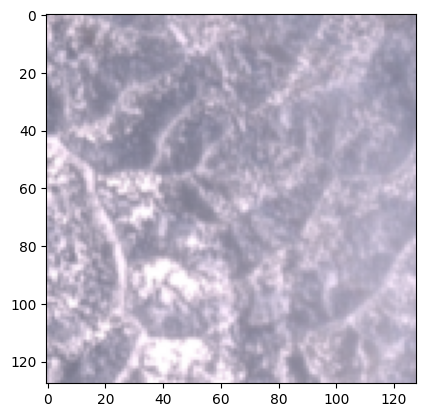

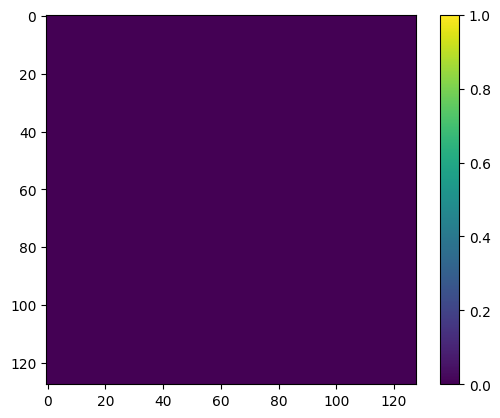

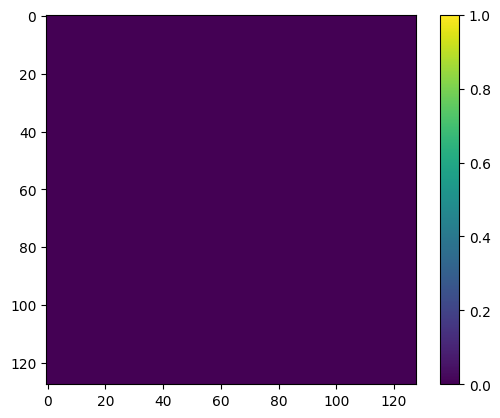

loss: tensor(1.4489, grad_fn=<DivBackward1>)


In [10]:

plt.figure()
plt.imshow(images_disp[0][:3].permute(1,2,0))
plt.show()
i=1

predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
a = predictions_softmax.argmax (1)
predictions_binary = torch.zeros (predictions_softmax.shape).scatter (1, a.unsqueeze (1), 1.0)

plt.figure()
img=plt.imshow(predictions_binary[0][i:i+1].permute(1,2,0),vmin=0, vmax=1)
plt.colorbar(img)
plt.show()


plt.figure()
img=plt.imshow(labels[0][i:i+1].permute(1,2,0),vmin=0, vmax=1)
plt.colorbar(img)
plt.show()

print("loss:",criterion(predictions,labels.float()))

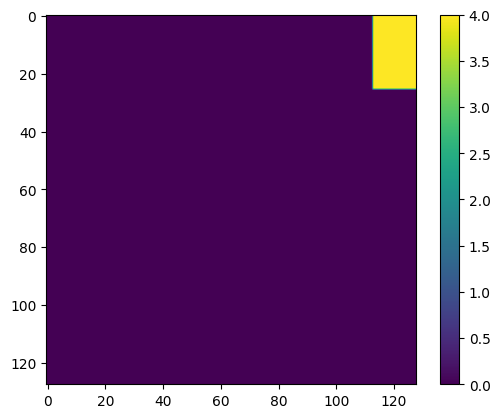

In [30]:
def from_one_hot(label):
    return np.argmax(label,0,keepdims=True)

l = (from_one_hot(labels[0]))

plt.figure()
img=plt.imshow(l.permute(1,2,0))
plt.colorbar(img)
plt.show()

In [35]:
images,labels,images_disp = next(test_it)
predictions = best_model(images)

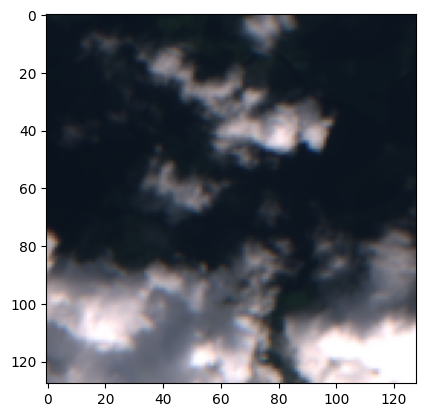

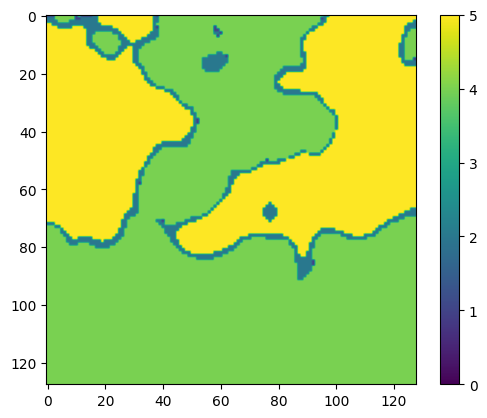

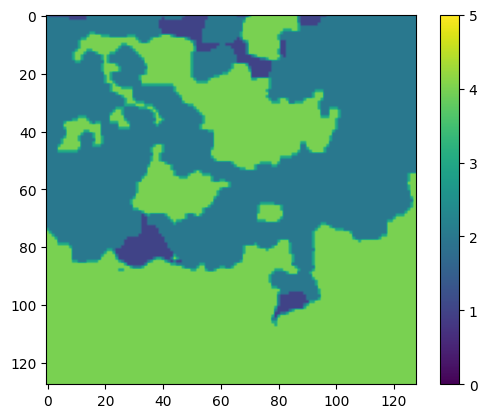

loss: tensor(1.0873, grad_fn=<DivBackward1>)


In [12]:
images,labels,images_disp = next(test_it)
predictions = best_model(images)

plt.figure()
plt.imshow(images_disp[0][:3].permute(1,2,0))
plt.show()

predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
a = predictions_softmax.argmax (1)
predictions_binary = torch.zeros (predictions_softmax.shape).scatter (1, a.unsqueeze (1), 1.0)

plt.figure()
img=plt.imshow(from_one_hot(predictions_binary[0]).permute(1,2,0),vmin=0, vmax=5)
plt.colorbar(img)
plt.show()


plt.figure()
img=plt.imshow(from_one_hot(labels[0]).permute(1,2,0),vmin=0, vmax=5)
plt.colorbar(img)
plt.show()

print("loss:",criterion(predictions,labels.float()))

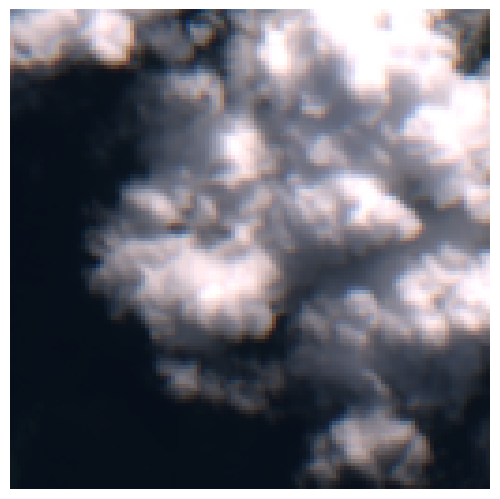

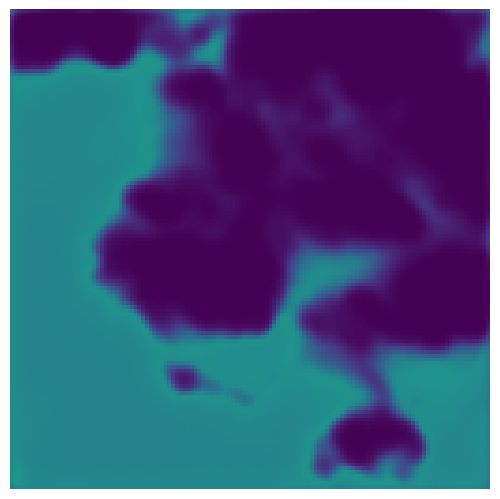

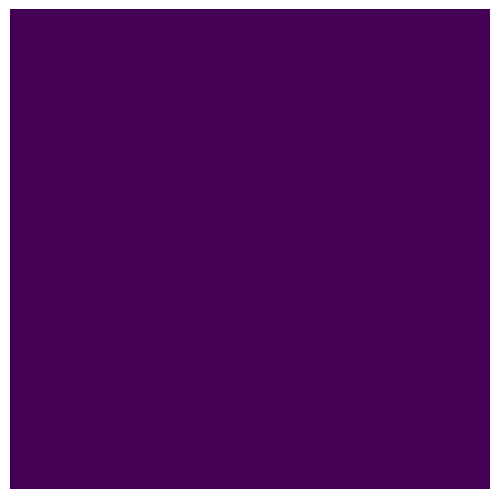

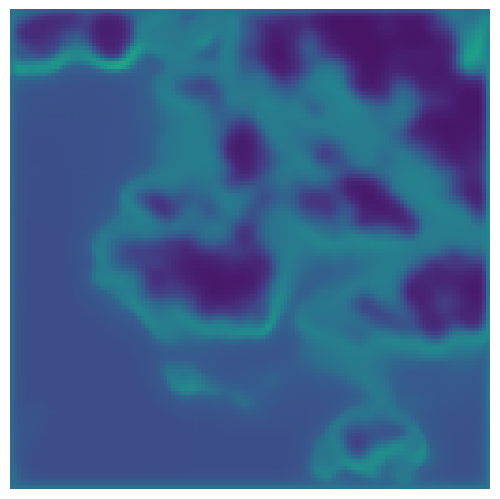

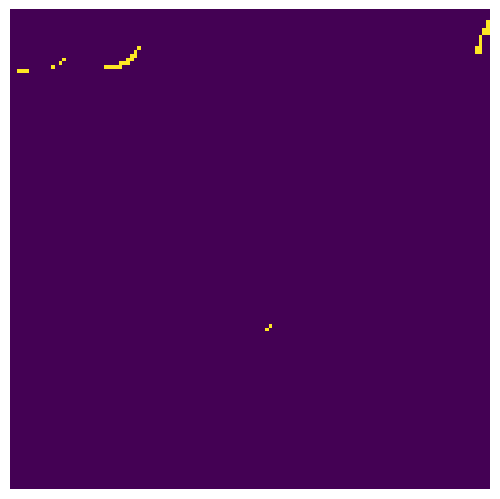

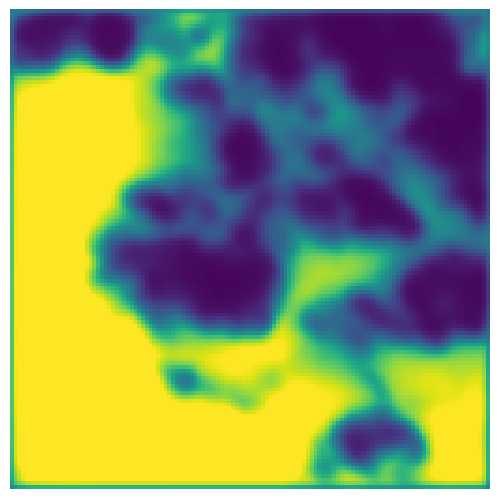

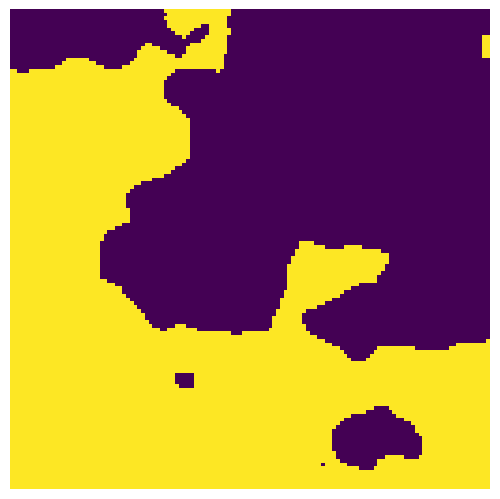

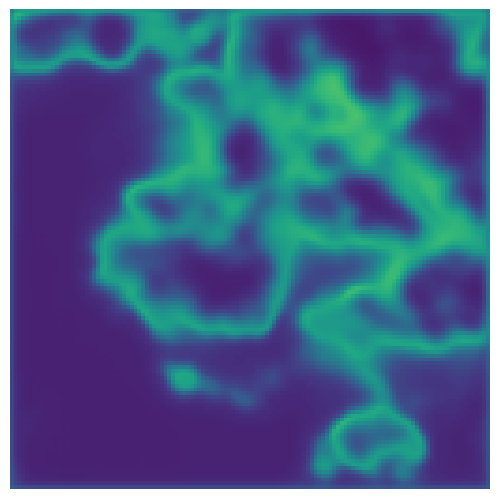

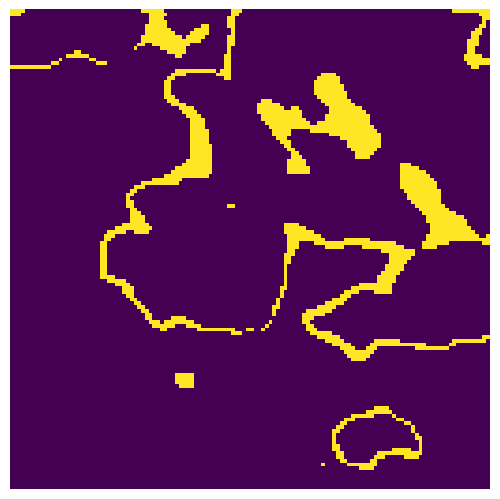

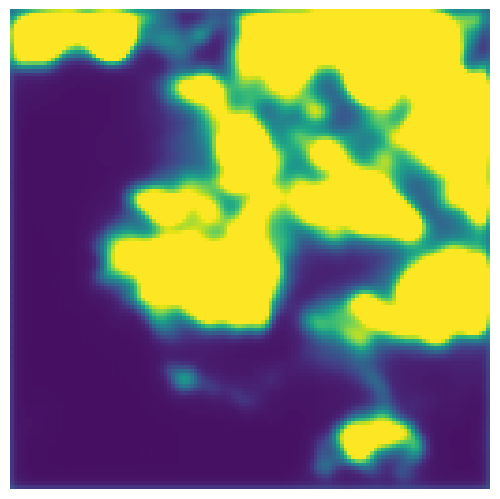

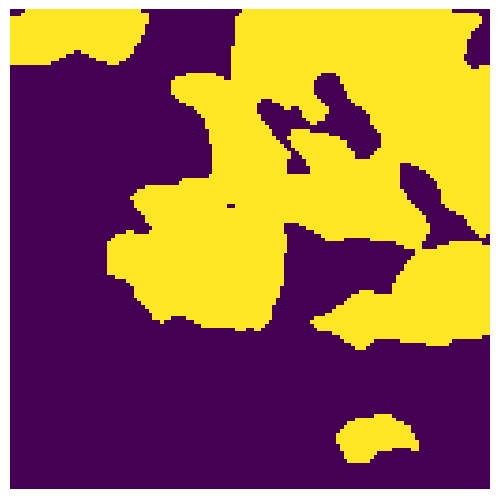

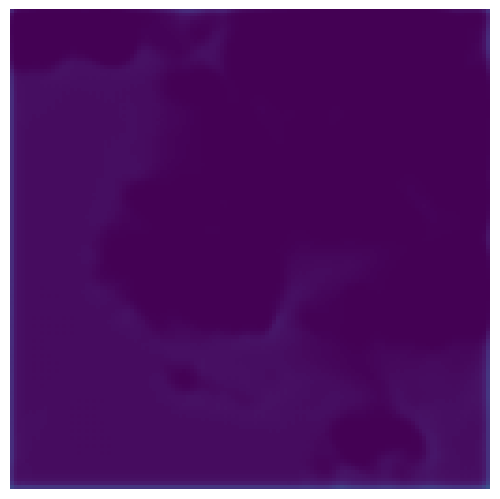

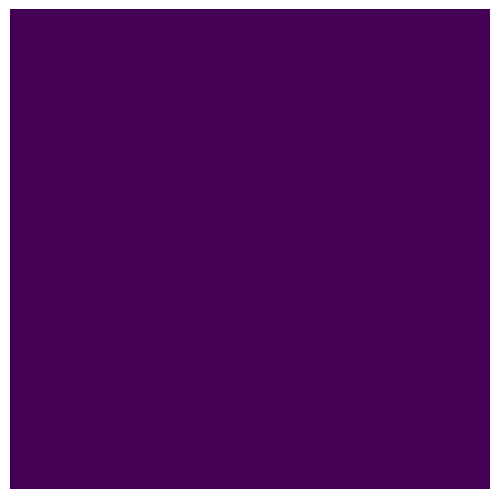

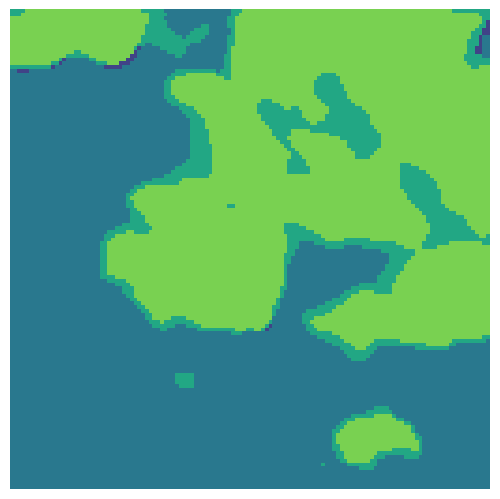

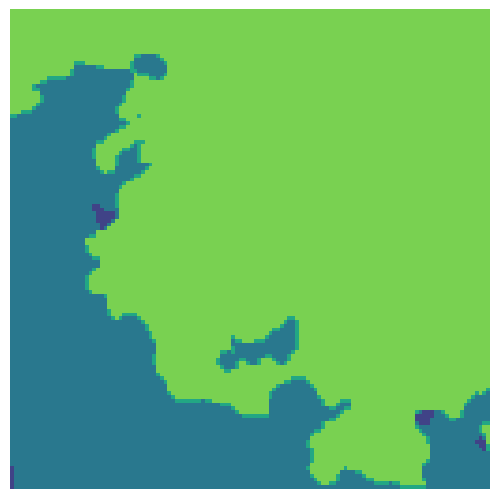

loss: tensor(1.0568, grad_fn=<DivBackward1>)


In [50]:
#For creating images
predictions = best_model(images)

predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
a = predictions_softmax.argmax (1)
predictions_binary = torch.zeros (predictions_softmax.shape).scatter (1, a.unsqueeze (1), 1.0)

fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(images[0][:3].permute(1,2,0))
plt.savefig('img.jpg', bbox_inches='tight',pad_inches=0)
plt.show()

for i in range(6):

    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(predictions_softmax[0][i:i+1].permute(1,2,0),vmin=0, vmax=0.5)
    plt.savefig('softmax'+str(i)+'.jpg', bbox_inches='tight',pad_inches=0)
    plt.show()

    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(predictions_binary[0][i:i+1].permute(1,2,0),vmin=0, vmax=1)
    plt.savefig('binary'+str(i)+'.jpg', bbox_inches='tight',pad_inches=0)
    plt.show()



fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(from_one_hot(predictions_binary[0]).permute(1,2,0),vmin=0, vmax=5)
plt.savefig('predictions.jpg', bbox_inches='tight',pad_inches=0)
plt.show()


fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(from_one_hot(labels[0]).permute(1,2,0),vmin=0, vmax=5)
plt.savefig('label.jpg', bbox_inches='tight',pad_inches=0)
plt.show()

print("loss:",criterion(predictions,labels.float()))


In [63]:
_,labels = next(iter(training_loader))

In [81]:

vs = [0,0,0,0,0,0]
total=0
for batch_nr, (_,labels,_) in enumerate(training_loader):
    for label in labels:
        i=0
        while i<6:
            sum = torch.sum(label[i:i+1]).item()
            vs[i]+=sum
            total+=sum
            i+=1
for batch_nr, (_,labels) in enumerate(validation_loader):
    for label in labels:
        i=0
        while i<6:
            sum = torch.sum(label[i:i+1]).item()
            vs[i]+=sum
            total+=sum
            i+=1
print(vs)
m = max(vs)
for i, e in enumerate(vs):
    vs[i]=m/e
print(vs)

[830, 521225, 199987, 339080, 326761, 70293]
[627.9819277108434, 1.0, 2.606294409136594, 1.537174118202194, 1.5951261013401232, 7.415034213933109]


In [32]:
#Evaluate
total = 0
correct = 0

for batch_nr, (images, labels,_) in enumerate(test_loader):

    predictions = best_model(images)

    predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
    predictions_binary = torch.zeros(predictions_softmax.shape).scatter (1, predictions_softmax.argmax(1).unsqueeze(1), 1.0)

    i=0
    while i<len(predictions):
        pred = from_one_hot(predictions_binary[i])
        label = from_one_hot(labels[i])

        y = torch.sum((pred==label))
        correct += y
        total += 128*128
        i+=1

print("Accuracy =", correct/total)

    

Accuracy = tensor(0.4490)


In [31]:
# IoU calculation

Union = [0,0,0,0,0,0] 
Intersection = [0,0,0,0,0,0]

for batch_nr, (images, labels,_) in enumerate(test_loader):

    predictions = best_model(images)

    predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
    predictions_binary = torch.zeros(predictions_softmax.shape).scatter (1, predictions_softmax.argmax(1).unsqueeze(1), 1.0)

    i=0
    while i<len(predictions):
        pred = from_one_hot(predictions_binary[i])
        label = from_one_hot(labels[i])

        for p_class in range(5):
            inter=torch.sum((pred==label)*(label==p_class))
            uni = (torch.sum((label==p_class)) + torch.sum((label==p_class)) - inter)
            Intersection[p_class] += inter.item()
            Union[p_class] += uni.item()
        i+=1

for p_class in range(5):
    try:
        print("IoU, class=",p_class,":",Intersection[p_class]/Union[p_class])
    except:
        print("IoU, class=",p_class,":","NAN (Union=0)")

IoU, class= 0 : 0.9711415996259694
IoU, class= 1 : 0.13817276235386258
IoU, class= 2 : 0.4351443809834437
IoU, class= 3 : 0.30329918172588016
IoU, class= 4 : 0.3387458065162614
